# Dissecting the fitESPconstrained script
We analyse the fitting routine implemented by Johannes piece by piece.

Original:
```bash
python3 ../bin/new_fit_esp_constrained.py horton_charges/costfunction_average.h5 200_ps_snapshot/0_initial_structure/snapshot.pdb 200_ps_snapshot/0_initial_structure/example.top ../fitting_constraint_files/atoms_in_charge_group.csv ../fitting_constraint_files/charge_group_total_charge.csv ../fitting_constraint_files/atoms_of_same_charge.csv updated_charges.top horton_charges/fitted_point_charges.csv -i ../fitting_constraint_files/hydrogen_per_atom.csv --verbose
```

In [11]:
%ls
import matplotlib.pyplot as plt
from smamp.tools import read_atom_numbers
from new_fit_esp_constrained import *
import h5py

200_ps_snapshot/       new_fit_esp_constrained.py@
cmd.sh                 __pycache__/
dissect_fitesp.ipynb@  refactored_fitESPconstrained.py@
horton_charges/        understand_lagrange_multiplier.ipynb@
lagrange-1.png         updated_charges.top


In [12]:
def unconstrainedMinimize(A_matrix, b_vector, C_scalar, debug = False):
    x = np.linalg.solve(A_matrix, b_vector)
    return x, A_matrix, b_vector

In [13]:
def old_constrainedMinimize(A_matrix, b_vector, C_scalar=0, D_matrix=None,
                        q_vector=np.array([0]), debug=False):

    N = b_vector.shape[0]
    M = q_vector.shape[0]
    
    if not isinstance(D_matrix, np.ndarray):
        D_matrix = np.atleast_2d(np.ones(N))

    # Cast everything to arrays
    A = np.atleast_2d(A_matrix)
    D = np.atleast_2d(D_matrix)
    b = np.atleast_1d(b_vector)
    q = np.atleast_1d(q_vector) 
    
    ###################################ü
    # WHY IS THERE A FACTOR OF 2??    
    
    # For old versions of numpy, block is not available. Fallback:
    if  float(np.version.version[2:]) < 13:
        A_con = np.bmat([[ 2*A, D.T            ],
                         [ D,   np.zeros((M,M))]])
        b_con = np.bmat([2*b, q]).T              

    else:
        A_con = np.block([[ 2*A, D.T ],
                          [ D,   np.zeros((M,M))]])
              
        b_con = np.block([2*b, q])              

    x = np.linalg.solve(A_con, b_con)

    return x, A_con, b_con


In [14]:
def constrainedMinimize(A_matrix, b_vector, C_scalar=0, D_matrix=None,
                        q_vector=np.array([0]), debug=False):

    N = b_vector.shape[0]
    M = q_vector.shape[0]
    
    if not isinstance(D_matrix, np.ndarray):
        D_matrix = np.atleast_2d(np.ones(N))    

    # Cast everything to arrays
    A = np.atleast_2d(A_matrix)
    D = np.atleast_2d(D_matrix)
    b = np.atleast_1d(b_vector)
    q = np.atleast_1d(q_vector) 
    
    # For old versions of numpy, block is not available. Fallback:
    if  float(np.version.version[2:]) < 13:
        A_con = np.bmat([[ A, D.T            ],
                         [ D, np.zeros((M,M))]])
        b_con = np.bmat([b, q]).T              

    else:
        A_con = np.block([[ A, D.T ],
                          [ D, np.zeros((M,M))]])
              
        b_con = np.block([b, q])              

    x = np.linalg.solve(A_con, b_con)

    return x, A_con, b_con

In [15]:
def read_horton_cost_function(file_name):
    cost_function = h5py.File(file_name)
    cost = cost_function['cost']
    A_horton = cost['A'][()]
    B_horton = cost['B'][()]
    C_horton = cost['C'][()]
    N_horton = cost['natom'][()]

    return A_horton, B_horton, C_horton, N_horton

In [16]:
def create_structure(infile_pdb, infile_top, infile_cost_h5, strip_string=':SOL,CL', implicitHbondingPartners = None):
        
    if implicitHbondingPartners is None:
        implicitHbondingPartners = read_atom_numbers()
        
    ua_ase_struct = ase.io.read(infile_pdb)
    ua_pmd_struct = pmd.load_file(infile_pdb)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ua_pmd_top = pmd.gromacs.GromacsTopologyFile(infile_top,parametrize=False)

    ua_pmd_top.strip(strip_string)
        #strip water and electrolyte from system (if not yet done in .top)
    ua_pmd_top.box = ua_pmd_struct.box # Needed because .pdb contains box info
    ua_pmd_top.positions = ua_pmd_struct.positions

    ua_names = [ a.name for a in ua_pmd_top.atoms ]
    ua_residues = [ a.residue.name for a in ua_pmd_top.atoms ]

    aa_ase_struct, aa_pmd_struct, aa_names, aa_residues = \
        insertHbyList(ua_ase_struct,ua_pmd_top,
        implicitHbondingPartners,1.0)

    ua_count = len(ua_ase_struct)     # united atoms structure
    aa_count = len(aa_ase_struct) # all atoms structure

    ua_ase_index = np.arange(ua_count)
    aa_ase_index = np.arange(aa_count)

    aa_atom_residue_list = list(zip(aa_names,aa_residues))
    aa_ase_index = range(aa_count)
    aa_ase2pmd = dict(zip(aa_ase_index,aa_atom_residue_list))
    aa_pmd2ase = dict(zip(aa_atom_residue_list,aa_ase_index))

    ua_atom_residue_list = list(zip(ua_names,ua_residues))
    ua_ase_index = range(ua_count)
    ua_ase2pmd = dict(zip(ua_ase_index,ua_atom_residue_list))
    ua_pmd2ase = dict(zip(ua_atom_residue_list,ua_ase_index))

    # TODO: distinction for ua and aa fitting:
    pmd_struct = ua_pmd_struct
    pmd_top = ua_pmd_top
    ase2pmd = ua_ase2pmd
    pmd2ase = ua_pmd2ase
    return pmd_struct, pmd_top, ase2pmd, pmd2ase

In [17]:
def read_constraint_files(infile_atoms_in_cg_csv, infile_cg_charges_csv, infile_atoms_of_same_charge_csv, ase2pmd):
    ### Charge Groups:
    # read in all charge groups and construct the corresponding constraints
    cg2ase, cg2cgtype, ncgtypes = read_AtomName_ChargeGroup(file_name=infile_atoms_in_cg_csv, ase2pmd=ase2pmd)

    cg_q = read_ChargeGroup_TotalCharge(file_name=infile_cg_charges_csv)

    cg2q  = [ cg_q[cg] for cg in cg2cgtype ]

    ### Same Charged Atoms
    sym2ase = read_SameChargedAtoms(
        file_name = infile_atoms_of_same_charge_csv, ase2pmd = ase2pmd)
    
    return cg2ase, cg2cgtype, ncgtypes, cg_q, cg_q, cg2q, sym2ase

In [18]:
def construct_constraint_matrices(cg2ase, N_horton, cg2q, sym2ase, qtot, debug):
    global D_matrix_cg_red
    global q_vector_cg_red
    D_matrix_cg_red, q_vector_cg_red = constructChargegroupConstraints(
        chargeGroups=cg2ase, N=N_horton, q=cg2q, debug=debug)

    global D_matrix_sym_red
    global q_vector_sym_red    
    D_matrix_sym_red, q_vector_sym_red = constructPairwiseSymmetryConstraints(
        charges=sym2ase, N=N_horton, symmetry=1.0, debug=False)

    D_matrix_qtot, q_vector_qtot = constructTotalChargeConstraint(
        charge=qtot, N=N_horton)

    D_matrix_all_red, q_vector_all_red = concatenated_constraints(
        D_matrices=[D_matrix_cg_red,D_matrix_sym_red,D_matrix_qtot],
        q_vectors=[q_vector_cg_red,q_vector_sym_red,q_vector_qtot])

    # remove redundant constraints 
    D_matrix_cg, q_vector_cg = construct_D_of_full_rank(
        D_matrix_cg_red, q_vector_cg_red)
    D_matrix_sym, q_vector_sym  = construct_D_of_full_rank(
        D_matrix_sym_red, q_vector_sym_red )
    D_matrix_all, q_vector_all = construct_D_of_full_rank(
        D_matrix_all_red, q_vector_all_red)
    
    if debug:
        D_matrix_cg_qtot_red, q_vector_cg_qtot_red = concatenated_constraints(
            D_matrices = [D_matrix_cg_red,D_matrix_qtot],
            q_vectors = [q_vector_cg_red,q_vector_qtot])
        D_matrix_cg_qtot, q_vector_cg_qtot = construct_D_of_full_rank(
            D_matrix_cg_qtot_red, q_vector_cg_qtot_red)

        D_matrix_sym_qtot_red, q_vector_sym_qtot_red = concatenated_constraints(
            D_matrices = [D_matrix_sym_red,D_matrix_qtot],
            q_vectors = [q_vector_sym_red,q_vector_qtot])
        D_matrix_sym_qtot, q_vector_sym_qtot = construct_D_of_full_rank(
            D_matrix_sym_qtot_red, q_vector_sym_qtot_red)

        # CG CONSTRAINTS
        rank_D_cg = np.linalg.matrix_rank(D_matrix_cg)
        rank_Dq_cg = np.linalg.matrix_rank(np.hstack((D_matrix_cg,
                                           np.atleast_2d(q_vector_cg).T)))
        # CG + QTOT CONSTRAINTS
        rank_D_cg_qtot = np.linalg.matrix_rank(D_matrix_cg_qtot)
        rank_Dq_cg_qtot = np.linalg.matrix_rank(np.hstack((D_matrix_cg_qtot,
                                           np.atleast_2d(q_vector_cg_qtot).T)))
        # SYM CONSTRAINTS
        rank_D_sym = np.linalg.matrix_rank(D_matrix_sym)
        rank_Dq_sym = np.linalg.matrix_rank(np.hstack((D_matrix_sym,
                                           np.atleast_2d(q_vector_sym).T)))
        # SYM + QTOT CONSTRAINTS
        rank_D_sym_qtot = np.linalg.matrix_rank(D_matrix_sym_qtot)
        rank_Dq_sym_qtot = np.linalg.matrix_rank(np.hstack((D_matrix_sym_qtot,
                                           np.atleast_2d(q_vector_sym_qtot).T)))
        # ALL CONSTRAINTS
        rank_D_all = np.linalg.matrix_rank(D_matrix_all)
        rank_Dq_all = np.linalg.matrix_rank(np.hstack((D_matrix_all,
                                           np.atleast_2d(q_vector_all).T)))
        
   
    return  D_matrix_all, q_vector_all, D_matrix_qtot, q_vector_qtot, D_matrix_cg_qtot, \
            q_vector_cg_qtot, D_matrix_sym_qtot, q_vector_sym_qtot

In [19]:
def fitESPconstrained(infile_pdb, infile_top, infile_cost_h5,
    infile_atoms_in_cg_csv, infile_cg_charges_csv,
    infile_atoms_of_same_charge_csv,
    qtot = 0.0, strip_string=':SOL,CL',
    implicitHbondingPartners = None,
    debug=False, outfile_top = None, outfile_csv = None):
    
    # A: construct all-atom representation from united-atom structure and topology
    pmd_struct, pmd_top, ase2pmd, pmd2ase = create_structure(infile_pdb, infile_top, infile_cost_h5, 
                                                             strip_string, implicitHbondingPartners)
    
    # B: read cost function
    A_horton, B_horton, C_horton, N_horton = read_horton_cost_function(file_name=infile_cost_h5)
    
    # C: read constraints files
    cg2ase, cg2cgtype, ncgtypes, cg_q, cg_q, cg2q, sym2ase = read_constraint_files(infile_atoms_in_cg_csv, infile_cg_charges_csv, infile_atoms_of_same_charge_csv, ase2pmd)

    # D: construct constraints matrices
    global D_matrix_all
    global q_vector_all
    D_matrix_all, q_vector_all, D_matrix_qtot, q_vector_qtot, D_matrix_cg_qtot, q_vector_cg_qtot, D_matrix_sym_qtot, q_vector_sym_qtot = \
    construct_constraint_matrices(cg2ase, N_horton, cg2q, sym2ase, qtot, debug)

    # E: Minimization
    ### Constrained minimization
    X, A, B = constrainedMinimize(A_matrix = A_horton,
                        b_vector = B_horton,
                        C_scalar = C_horton,
                        D_matrix = D_matrix_all,
                        q_vector = q_vector_all,
                        debug    = debug)

    ase2pmd_df = pd.DataFrame(ase2pmd).T
    ase2pmd_df.columns = ['atom','residue']
    ase2pmd_df['q'] = X[:N_horton]

    # additional debug cases
    if debug:
        ### Unconstrained minimization
        X_unconstrained, A_unconstrained, B_unconstrained = \
            unconstrainedMinimize(A_matrix = A_horton,
                        b_vector = B_horton,
                        C_scalar = C_horton,
                        debug    = debug)

        ### Total charge constraint minimization
        X_qtot_constraint, A_qtot_constraint, B_qtot_constraint = \
            constrainedMinimize(A_matrix = A_horton,
                        b_vector = B_horton,
                        C_scalar = C_horton,
                        D_matrix = D_matrix_qtot,
                        q_vector = q_vector_qtot,
                        debug    = debug)

        ### Charge group & total charge constraint minimization 
        X_cg_qtot, A_cg_qtot, B_cg_qtot = \
            constrainedMinimize(A_matrix = A_horton,
                        b_vector = B_horton,
                        C_scalar = C_horton,
                        D_matrix = D_matrix_cg_qtot,
                        q_vector = q_vector_cg_qtot,
                        debug    = debug)

       ### Symmetry & total charge constraint minimization
        X_sym_qtot, A_sym_qtot, B_sym_qtot = \
            constrainedMinimize(A_matrix = A_horton,
                        b_vector = B_horton,
                        C_scalar = C_horton,
                        D_matrix = D_matrix_sym_qtot,
                        q_vector = q_vector_sym_qtot,
                        debug    = debug)


        ase2pmd_df['q_unconstrained'] = X_unconstrained
        ase2pmd_df['q_qtot_constrained'] = X_qtot_constraint[:N_horton]
        ase2pmd_df['q_cg_qtot_constrained'] = X_cg_qtot[:N_horton]
        ase2pmd_df['q_sym_qtot_constrained'] = X_sym_qtot[:N_horton]

        checkChargeGroups(ase2pmd_df,cg2ase,cg2cgtype,cg2q)
        checkSymmetries(ase2pmd_df,sym2ase)


    # one line to assign unique charge group numbers starting at 1 to ASE indices
    ase2cg = dict([(idx, cgnr+1) for cgnr,cg in enumerate(cg2ase) for idx in cg])

    for a in pmd_top.atoms:
        a.charge = X[ pmd2ase[(a.name,a.residue.name)] ]
        a.cgnr = ase2cg[ pmd2ase[(a.name,a.residue.name)] ]

    if outfile_top:
        pmd_top.save(outfile_top, overwrite=True)

    if outfile_csv:
        ase2pmd_df.to_csv(outfile_csv, sep=',')

    return X[:N_horton], X[N_horton:], ase2pmd_df, cg2ase, cg2cgtype, cg2q, sym2ase

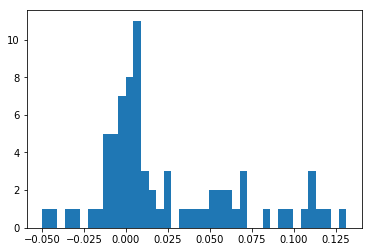

In [20]:
def main():
    # Total Charge
    total_charge = 0
    
    # Hydrogen insertion rules
    implicitHbondingPartners = read_atom_numbers()

    q, lagrange_multiplier, info_df, cg2ase, cg2cgtype, cg2q, sym2ase = \
    fitESPconstrained(infile_pdb = "200_ps_snapshot/0_initial_structure/snapshot.pdb",
              infile_top = "200_ps_snapshot/0_initial_structure/example.top",
              infile_cost_h5 = "horton_charges/costfunction_average.h5",
              infile_atoms_in_cg_csv = "../fitting_constraint_files/atoms_in_charge_group.csv",
              infile_cg_charges_csv = "../fitting_constraint_files/charge_group_total_charge.csv",
              infile_atoms_of_same_charge_csv = "../fitting_constraint_files/atoms_of_same_charge.csv",
              qtot = total_charge, strip_string=':SOL,CL',
              implicitHbondingPartners = implicitHbondingPartners,
              debug = True)
    
    return lagrange_multiplier
l = main()

plt.hist(l, 40)
plt.show()

## Compare constrained and unconstrained Min
Are constrained min with empty constraints and unconstraint min equivalent?

0.007463604221824988
0.08960841801425566


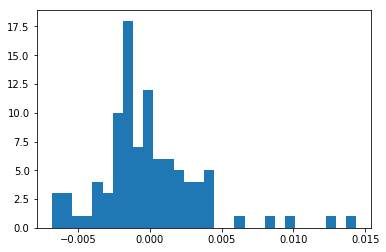

In [29]:
A, B, C, N = read_horton_cost_function(file_name="horton_charges/costfunction_average.h5")

# Unconstrained minimization
X_un, A_un, B_un = unconstrainedMinimize(A_matrix=A, b_vector=B, C_scalar=C)

# Constrained minimization
X, A_, B_ = constrainedMinimize(A_matrix=A, b_vector=B, C_scalar=C)

diff = X[0:len(X_un)] - X_un

print(sum(X_un))
print(sum(X))

plt.hist(diff, 30)
plt.show()

We can see that the two minimization methods are not equivalent, but very similar.

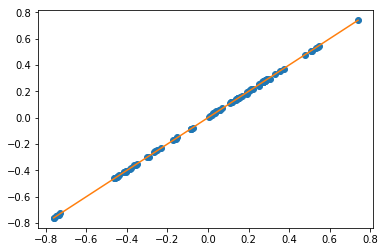

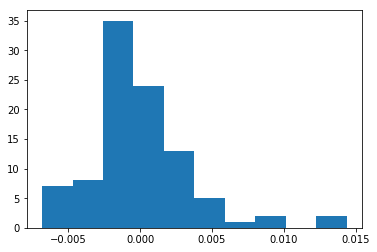

In [27]:
X_un, A_un, B_un = unconstrainedMinimize(A_matrix=A, b_vector=B, C_scalar=C)
X, A_, B_ = constrainedMinimize(A_matrix=A, b_vector=B, C_scalar=C)

plt.plot(X[:len(X_un)], X_un, lw=0, marker='o')
plt.plot([min(X), max(X)], [min(X), max(X)])
plt.show()

diff = X[:len(X_un)] - X_un
plt.hist(diff)
plt.show()

In [ ]:
print(D_matrix_all)
print(q_vector_all)
X, A_, B_ = constrainedMinimize(A_matrix, b_vector, C_scalar=0, 
                                D_matrix=D_matrix_all,
                                q_vector=q_vector_all)
X_un, A_, B_ = constrainedMinimize(A_matrix, b_vector, C_scalar=0, 
                                D_matrix=D_matrix_all,
                                q_vector=q_vector_all)
plt.plot(X, X_new, lw=0, marker='o')
plt.plot([min(X), max(X)], [min(X), max(X)])
plt.show()

diff = X - X_new
plt.hist(diff)
plt.show()
